## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras
from keras.layers import BatchNormalization
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    """
    Code Here
    建立你的神經網路
    """
    # input
    input_layer = keras.layers.Input(input_shape)
    
    # hidden
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    # output
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0, 0.25, 0.5, 0.8]
redice_lr_patient = [5, 20]

In [9]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor = reduce_factor, 
                                  min_lr=1e-12, 
                                  monitor='val_loss', 
                                  patience = reduce_patient, 
                                  verbose=1)
     
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.00, reduce_patient: 5
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
b

50000/50000 [==============================] - 8s 164us/step - loss: 3.1375 - accuracy: 0.0947 - val_loss: 2.9465 - val_accuracy: 0.0965
Epoch 11/25
50000/50000 [==============================] - 8s 161us/step - loss: 3.1377 - accuracy: 0.0951 - val_loss: 2.9914 - val_accuracy: 0.0976
Epoch 12/25
50000/50000 [==============================] - 8s 161us/step - loss: 3.1370 - accuracy: 0.0941 - val_loss: 3.0279 - val_accuracy: 0.0984
Epoch 13/25
50000/50000 [==============================] - 8s 162us/step - loss: 3.1378 - accuracy: 0.0945 - val_loss: 3.0567 - val_accuracy: 0.0979
Epoch 14/25
50000/50000 [==============================] - 6s 122us/step - loss: 3.1372 - accuracy: 0.0940 - val_loss: 3.0784 - val_accuracy: 0.0969
Epoch 15/25
50000/50000 [==============================] - 6s 119us/step - loss: 3.1376 - accuracy: 0.0945 - val_loss: 3.0943 - val_accuracy: 0.0955
Epoch 16/25
50000/50000 [==============================] - 7s 144us/step - loss: 3.1372 - accuracy: 0.0948 - val_loss:

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 11s 224us/step - loss: 3.0685 - accuracy: 0.0977 - val_loss: 2.3836 - val_accuracy: 0.0969
Epoch 2/25
50000/50000 [==============================] - 8s 167us/step - loss: 3.0677 - accuracy: 0.0981 - val_loss: 2.3995 - val_accuracy: 0.0969
Epoch 3/25
50000/50000 [==============================] - 8s 162us/step - loss: 3.0685 - accuracy: 0.0971 - val_loss: 2.4445 - val_accuracy: 0.0997
Epoch 4/25
50000/50000 [==============================] - 9s 173us/step - loss: 3.0669 - accuracy: 0.0978 - val_loss: 2.5090 - val_accuracy: 0.0992
Epoch 5/25
50000/50000 [==============================] - 8s 164us/step - loss: 3.0687 - accuracy: 0.0974 - val_loss: 2.5822 - val_accuracy: 0.1006
Epoch 6/25
50000/50000 [==============================] - 8s 163us/step - loss: 3.0677 - accuracy: 0.0966 - val_loss: 2.6573 - val_accuracy: 0.0996
Epoch 7/25
50000/50000 [==============================] - 8s 

50000/50000 [==============================] - 8s 163us/step - loss: 2.9255 - accuracy: 0.1096 - val_loss: 2.9298 - val_accuracy: 0.1081
Epoch 21/25
50000/50000 [==============================] - 8s 166us/step - loss: 2.9261 - accuracy: 0.1087 - val_loss: 2.9309 - val_accuracy: 0.1081
Epoch 22/25
50000/50000 [==============================] - 9s 170us/step - loss: 2.9252 - accuracy: 0.1089 - val_loss: 2.9313 - val_accuracy: 0.1081
Epoch 23/25
50000/50000 [==============================] - 9s 175us/step - loss: 2.9254 - accuracy: 0.1094 - val_loss: 2.9317 - val_accuracy: 0.1080
Epoch 24/25
50000/50000 [==============================] - 9s 176us/step - loss: 2.9255 - accuracy: 0.1089 - val_loss: 2.9318 - val_accuracy: 0.1081
Epoch 25/25
50000/50000 [==============================] - 8s 168us/step - loss: 2.9259 - accuracy: 0.1086 - val_loss: 2.9321 - val_accuracy: 0.1082
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 20
Model: "model_6"
__________________________________________

50000/50000 [==============================] - 8s 164us/step - loss: 2.9942 - accuracy: 0.0963 - val_loss: 2.4779 - val_accuracy: 0.0956
Epoch 5/25
50000/50000 [==============================] - 8s 167us/step - loss: 2.9934 - accuracy: 0.0965 - val_loss: 2.5474 - val_accuracy: 0.0954
Epoch 6/25
50000/50000 [==============================] - 9s 173us/step - loss: 2.9931 - accuracy: 0.0971 - val_loss: 2.6167 - val_accuracy: 0.0937
Epoch 7/25
50000/50000 [==============================] - 8s 163us/step - loss: 2.9933 - accuracy: 0.0960 - val_loss: 2.6838 - val_accuracy: 0.0927
Epoch 8/25
50000/50000 [==============================] - 9s 181us/step - loss: 2.9930 - accuracy: 0.0964 - val_loss: 2.7464 - val_accuracy: 0.0923
Epoch 9/25
50000/50000 [==============================] - 10s 198us/step - loss: 2.9935 - accuracy: 0.0958 - val_loss: 2.8018 - val_accuracy: 0.0936
Epoch 10/25
50000/50000 [==============================] - 9s 183us/step - loss: 2.9935 - accuracy: 0.0960 - val_loss: 2.8

50000/50000 [==============================] - 9s 182us/step - loss: 2.9797 - accuracy: 0.0979 - val_loss: 2.9726 - val_accuracy: 0.1024
Epoch 24/25
50000/50000 [==============================] - 8s 162us/step - loss: 2.9796 - accuracy: 0.0988 - val_loss: 2.9729 - val_accuracy: 0.1022
Epoch 25/25
50000/50000 [==============================] - 8s 162us/step - loss: 2.9802 - accuracy: 0.0985 - val_loss: 2.9730 - val_accuracy: 0.1023
Numbers of exp: 8, reduce_factor: 0.00, reduce_patient: 5
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_25 (Batc (None, 512)               2048      
____________________________

50000/50000 [==============================] - 9s 184us/step - loss: 3.0587 - accuracy: 0.0994 - val_loss: 2.6910 - val_accuracy: 0.0990
Epoch 8/25
50000/50000 [==============================] - 9s 175us/step - loss: 3.0591 - accuracy: 0.0984 - val_loss: 2.7564 - val_accuracy: 0.1004
Epoch 9/25
50000/50000 [==============================] - 9s 176us/step - loss: 3.0590 - accuracy: 0.0982 - val_loss: 2.8168 - val_accuracy: 0.1004
Epoch 10/25
50000/50000 [==============================] - 9s 176us/step - loss: 3.0585 - accuracy: 0.0983 - val_loss: 2.8708 - val_accuracy: 0.1006
Epoch 11/25
50000/50000 [==============================] - 9s 173us/step - loss: 3.0575 - accuracy: 0.0990 - val_loss: 2.9174 - val_accuracy: 0.0992
Epoch 12/25
50000/50000 [==============================] - 9s 175us/step - loss: 3.0578 - accuracy: 0.0983 - val_loss: 2.9562 - val_accuracy: 0.0995
Epoch 13/25
50000/50000 [==============================] - 8s 161us/step - loss: 3.0575 - accuracy: 0.0988 - val_loss: 2

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 11s 222us/step - loss: 3.0434 - accuracy: 0.0970 - val_loss: 2.3320 - val_accuracy: 0.0922
Epoch 2/25
50000/50000 [==============================] - 8s 160us/step - loss: 3.0435 - accuracy: 0.0973 - val_loss: 2.3649 - val_accuracy: 0.0999
Epoch 3/25
50000/50000 [==============================] - 8s 155us/step - loss: 3.0432 - accuracy: 0.0969 - val_loss: 2.4174 - val_accuracy: 0.1045
Epoch 4/25
50000/50000 [==============================] - 8s 164us/step - loss: 3.0431 - accuracy: 0.0973 - val_loss: 2.4810 - val_accuracy: 0.1029
Epoch 5/25
50000/50000 [==============================] - 9s 170us/step - loss: 3.0427 - accuracy: 0.0965 - val_loss: 2.5518 - val_accuracy: 0.1025
Epoch 6/25
50000/50000 [==============================] - 8s 160us/step - loss: 3.0430 - accuracy: 0.0973 - val_loss: 2.6245 - val_accuracy: 0.1026
Epoch 7/25
50000/50000 [==============================] - 9s 

50000/50000 [==============================] - 8s 164us/step - loss: 2.9567 - accuracy: 0.1076 - val_loss: 2.9583 - val_accuracy: 0.1094
Epoch 21/25
50000/50000 [==============================] - 8s 164us/step - loss: 2.9559 - accuracy: 0.1068 - val_loss: 2.9596 - val_accuracy: 0.1095
Epoch 22/25
50000/50000 [==============================] - 7s 150us/step - loss: 2.9552 - accuracy: 0.1079 - val_loss: 2.9603 - val_accuracy: 0.1098
Epoch 23/25
50000/50000 [==============================] - 8s 166us/step - loss: 2.9559 - accuracy: 0.1084 - val_loss: 2.9609 - val_accuracy: 0.1097
Epoch 24/25
50000/50000 [==============================] - 9s 174us/step - loss: 2.9578 - accuracy: 0.1074 - val_loss: 2.9611 - val_accuracy: 0.1097
Epoch 25/25
50000/50000 [==============================] - 8s 163us/step - loss: 2.9572 - accuracy: 0.1073 - val_loss: 2.9612 - val_accuracy: 0.1097
Numbers of exp: 13, reduce_factor: 0.50, reduce_patient: 20
Model: "model_14"
________________________________________

50000/50000 [==============================] - 9s 173us/step - loss: 3.0942 - accuracy: 0.0887 - val_loss: 2.5185 - val_accuracy: 0.0843
Epoch 5/25
50000/50000 [==============================] - 9s 172us/step - loss: 3.0939 - accuracy: 0.0881 - val_loss: 2.5984 - val_accuracy: 0.0868
Epoch 6/25
50000/50000 [==============================] - 9s 183us/step - loss: 3.0945 - accuracy: 0.0876 - val_loss: 2.6776 - val_accuracy: 0.0851
Epoch 7/25
50000/50000 [==============================] - 8s 166us/step - loss: 3.0944 - accuracy: 0.0878 - val_loss: 2.7519 - val_accuracy: 0.0854
Epoch 8/25
50000/50000 [==============================] - 8s 163us/step - loss: 3.0948 - accuracy: 0.0880 - val_loss: 2.8194 - val_accuracy: 0.0875
Epoch 9/25
50000/50000 [==============================] - 8s 168us/step - loss: 3.0933 - accuracy: 0.0875 - val_loss: 2.8786 - val_accuracy: 0.0868
Epoch 10/25
50000/50000 [==============================] - 9s 174us/step - loss: 3.0941 - accuracy: 0.0876 - val_loss: 2.92

50000/50000 [==============================] - 9s 174us/step - loss: 3.0556 - accuracy: 0.1008 - val_loss: 3.0514 - val_accuracy: 0.0988
Epoch 24/25
50000/50000 [==============================] - 9s 171us/step - loss: 3.0560 - accuracy: 0.1013 - val_loss: 3.0517 - val_accuracy: 0.0987
Epoch 25/25
50000/50000 [==============================] - 9s 179us/step - loss: 3.0556 - accuracy: 0.1007 - val_loss: 3.0520 - val_accuracy: 0.0987
Numbers of exp: 16, reduce_factor: 0.00, reduce_patient: 5
Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_49 (Batc (None, 512)               2048      
__________________________

50000/50000 [==============================] - 9s 173us/step - loss: 3.0007 - accuracy: 0.1045 - val_loss: 2.6752 - val_accuracy: 0.1009
Epoch 8/25
50000/50000 [==============================] - 8s 168us/step - loss: 3.0003 - accuracy: 0.1059 - val_loss: 2.7374 - val_accuracy: 0.0989
Epoch 9/25
50000/50000 [==============================] - 8s 162us/step - loss: 3.0006 - accuracy: 0.1048 - val_loss: 2.7938 - val_accuracy: 0.0982
Epoch 10/25
50000/50000 [==============================] - 8s 163us/step - loss: 3.0011 - accuracy: 0.1046 - val_loss: 2.8431 - val_accuracy: 0.0974
Epoch 11/25
50000/50000 [==============================] - 9s 171us/step - loss: 3.0012 - accuracy: 0.1050 - val_loss: 2.8841 - val_accuracy: 0.0984
Epoch 12/25
50000/50000 [==============================] - 8s 163us/step - loss: 3.0004 - accuracy: 0.1043 - val_loss: 2.9180 - val_accuracy: 0.0984
Epoch 13/25
50000/50000 [==============================] - 8s 163us/step - loss: 3.0006 - accuracy: 0.1048 - val_loss: 2

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 11s 221us/step - loss: 3.0749 - accuracy: 0.0909 - val_loss: 2.3481 - val_accuracy: 0.0962
Epoch 2/25
50000/50000 [==============================] - 8s 163us/step - loss: 3.0754 - accuracy: 0.0906 - val_loss: 2.3774 - val_accuracy: 0.0936
Epoch 3/25
50000/50000 [==============================] - 9s 174us/step - loss: 3.0749 - accuracy: 0.0917 - val_loss: 2.4428 - val_accuracy: 0.0927
Epoch 4/25
50000/50000 [==============================] - 8s 168us/step - loss: 3.0750 - accuracy: 0.0908 - val_loss: 2.5169 - val_accuracy: 0.0915
Epoch 5/25
50000/50000 [==============================] - 8s 163us/step - loss: 3.0746 - accuracy: 0.0918 - val_loss: 2.5917 - val_accuracy: 0.0927
Epoch 6/25
50000/50000 [==============================] - 8s 167us/step - loss: 3.0739 - accuracy: 0.0920 - val_loss: 2.6645 - val_accuracy: 0.0927
Epoch 7/25
50000/50000 [==============================] - 8s 

50000/50000 [==============================] - 8s 167us/step - loss: 2.9827 - accuracy: 0.1069 - val_loss: 2.9657 - val_accuracy: 0.1096
Epoch 21/25
50000/50000 [==============================] - 8s 169us/step - loss: 2.9828 - accuracy: 0.1058 - val_loss: 2.9670 - val_accuracy: 0.1096
Epoch 22/25
50000/50000 [==============================] - 9s 171us/step - loss: 2.9839 - accuracy: 0.1067 - val_loss: 2.9677 - val_accuracy: 0.1092
Epoch 23/25
50000/50000 [==============================] - 8s 163us/step - loss: 2.9845 - accuracy: 0.1069 - val_loss: 2.9680 - val_accuracy: 0.1092
Epoch 24/25
50000/50000 [==============================] - 8s 168us/step - loss: 2.9826 - accuracy: 0.1072 - val_loss: 2.9679 - val_accuracy: 0.1094
Epoch 25/25
50000/50000 [==============================] - 8s 165us/step - loss: 2.9832 - accuracy: 0.1066 - val_loss: 2.9685 - val_accuracy: 0.1093
Numbers of exp: 21, reduce_factor: 0.50, reduce_patient: 20
Model: "model_22"
________________________________________

50000/50000 [==============================] - 8s 163us/step - loss: 3.0110 - accuracy: 0.0972 - val_loss: 2.5133 - val_accuracy: 0.0895
Epoch 5/25
50000/50000 [==============================] - 8s 153us/step - loss: 3.0115 - accuracy: 0.0976 - val_loss: 2.5754 - val_accuracy: 0.0886
Epoch 6/25
50000/50000 [==============================] - 8s 165us/step - loss: 3.0116 - accuracy: 0.0974 - val_loss: 2.6360 - val_accuracy: 0.0904
Epoch 7/25
50000/50000 [==============================] - 8s 166us/step - loss: 3.0120 - accuracy: 0.0968 - val_loss: 2.6952 - val_accuracy: 0.0905
Epoch 8/25
50000/50000 [==============================] - 8s 165us/step - loss: 3.0115 - accuracy: 0.0967 - val_loss: 2.7509 - val_accuracy: 0.0901
Epoch 9/25
50000/50000 [==============================] - 8s 165us/step - loss: 3.0117 - accuracy: 0.0961 - val_loss: 2.8014 - val_accuracy: 0.0921
Epoch 10/25
50000/50000 [==============================] - 9s 174us/step - loss: 3.0115 - accuracy: 0.0960 - val_loss: 2.84

Epoch 24/25
50000/50000 [==============================] - 8s 165us/step - loss: 2.8732 - accuracy: 0.1162 - val_loss: 2.8628 - val_accuracy: 0.1176
Epoch 25/25
50000/50000 [==============================] - 8s 165us/step - loss: 2.8740 - accuracy: 0.1154 - val_loss: 2.8627 - val_accuracy: 0.1176


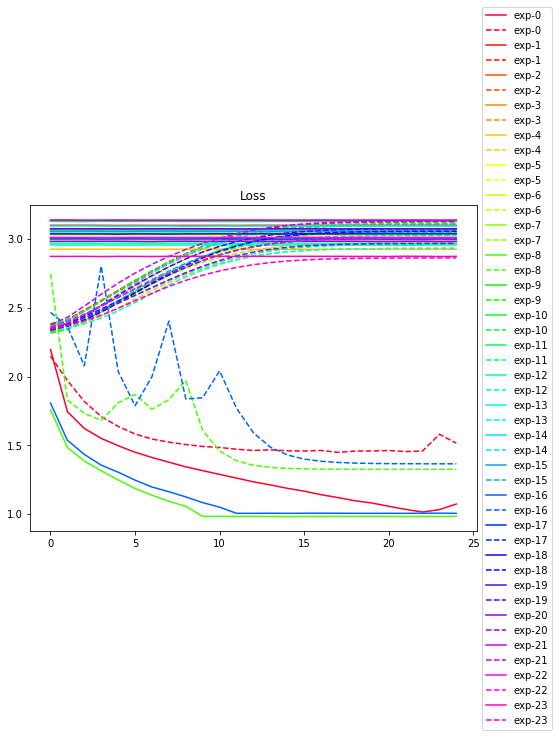

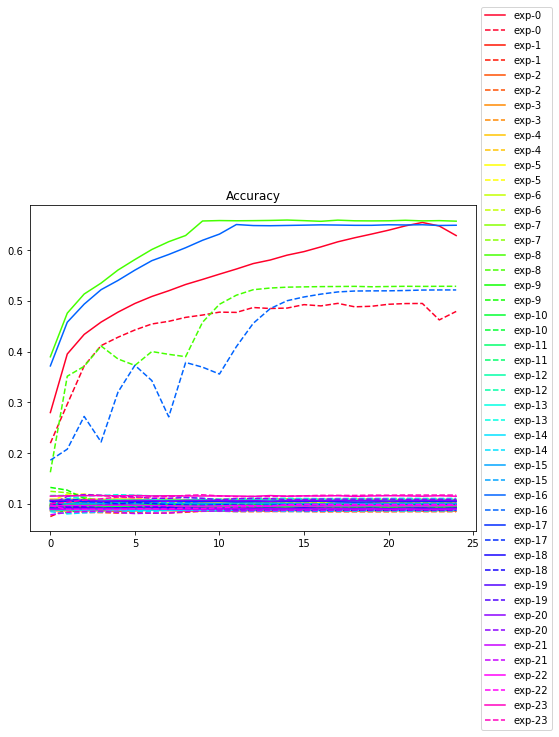

In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()